In [11]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:
ts = pd.read_csv('./data/ts14-15.csv')
ts = ts.drop('Unnamed: 0', 1)

# Build team index
teams = ts.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

ts = pd.merge(ts, teams, left_on='home_team', right_on='team', how='left')
ts = ts.rename(columns = {'i': 'i_home'}).drop('team', 1)
ts = pd.merge(ts, teams, left_on='away_team', right_on='team', how='left')
ts = ts.rename(columns = {'i': 'i_away'}).drop('team', 1)

ts = ts.sort_values(by='kick_off', ascending=1)

# Observed goals stats (Eyeball Poisson)
observed_home_goals = ts.home_score.values
observed_away_goals = ts.away_score.values

home_team = ts.i_home.values
away_team = ts.i_away.values

num_teams = len(ts.i_home.drop_duplicates())
num_games = len(home_team)

# Add back to back fixture round index t
fixtures_per_round = num_teams/2
num_rounds = 38

rounds = np.array([[x]*(fixtures_per_round) for x in range(1,39)]).flatten()
ts['t'] = 1
ts['t'] = rounds

grouped = ts.groupby('t')

observed_home_goals = np.zeros((num_rounds,fixtures_per_round))
observed_away_goals = np.zeros((num_rounds,fixtures_per_round))
home_team = np.zeros((num_rounds,fixtures_per_round))
away_team = np.zeros((num_rounds,fixtures_per_round))

for t, group in grouped:
    observed_home_goals[t-1] = group.home_score.values
    observed_away_goals[t-1] = group.away_score.values
    home_team[t-1] = group.i_home.values
    away_team[t-1] = group.i_away.values
    
observed_home_goals = observed_home_goals.astype(np.int64)
observed_away_goals = observed_away_goals.astype(np.int64)
home_team = home_team.astype(np.int64)
away_team = away_team.astype(np.int64)

T = observed_home_goals.shape[0]

In [13]:
# Calculate time delta between games
# Ordered ascending dates with team
ts_home = ts[['home_team', 'kick_off']]
ts_away = ts[['away_team', 'kick_off']]

ts_home.columns = ['team', 'date']
ts_away.columns = ['team', 'date']

dates = ts_home.append(ts_away)

dates = dates.sort_values(by='date', ascending=1)

dates = dates.reset_index(drop=False)

dates['date'] = pd.to_datetime(dates['date'])
dates['time_delta'] = 0

# Group by team
dates_grouped = dates.groupby('team')

# calculate time delta
for name, group in dates_grouped:
    time_delta = group['date'].diff()
    days = (time_delta / np.timedelta64(1, 'D'))
    days = days.fillna(0).astype(int)
    dates.ix[days.index,'time_delta'] = days

# add to original dataframe where (team in home and date OR team in away and date)
dates = dates.set_index('index')

ts['home_time_delta'] = 0
ts['away_time_delta'] = 0

dates0 = dates.ix[dates.index.duplicated()]
dates1 = dates.ix[-dates.index.duplicated()]

ts = ts.sort_index()

dates0 = dates0.sort_index()
dates1 = dates1.sort_index()

ts.set_value(dates0['team'] == ts['home_team'],['home_time_delta'],dates0['time_delta'])
ts.set_value(dates1['team'] == ts['home_team'],['home_time_delta'],dates1['time_delta'])

ts.set_value(dates0['team'] == ts['away_team'],['away_time_delta'],dates0['time_delta'])
ts.set_value(dates1['team'] == ts['away_team'],['away_time_delta'],dates1['time_delta'])

ts = ts.sort_values(by='kick_off', ascending=1)

# TODO: Describe the data model
#        - 20 teams, each playing against the other twice results in 10*38=380 fixtures
#        - Fixtures are organised in 19 "Back to back" fixture rounds, meaning
#          each team plays once home and away in each round (not against the same opponent)
#        - Hence 20 teams play twice each in each b2b round, amounting to 20 fixtures 
# TODO: Make sure that the right teams are selected
# ACTUALLY: B2B doesn't make sense, let's call it round, meaning every team played once, twice, etc.
home_deltas = ts[ts.t == 1]['home_time_delta'].values

## Define model definition and sampling

In [14]:
def define_model(to_week):
    T = to_week
    
    with pm.Model() as model:
        # global model parameters
        home        = pm.Normal('home',      0, .0001)
        tau_att     = pm.Gamma('tau_att',   .1, .1)
        tau_def     = pm.Gamma('tau_def',   .1, .1)
        intercept   = pm.Normal('intercept', 0, .0001)

        # Make auto-regressive
        # Each t indexes a home or away fixture for each team (10 games with 20 teams)
        # [1] Define t0
        # TODO: Incorporate time_deltas in tau
        atts_ni = [pm.Normal("atts_ni0", mu = 0, tau = tau_att, shape = num_teams)]
        defs_ni = [pm.Normal("defs_ni0", mu = 0, tau = tau_def, shape = num_teams)]

        # Identifiability
        atts = [pm.Deterministic('atts0', atts_ni[0] - tt.mean(atts_ni[0]))]
        defs = [pm.Deterministic('defs0', defs_ni[0] - tt.mean(defs_ni[0]))]

        home_thetas = [tt.exp(intercept + home + atts[0][home_team[0,:]] + defs[0][away_team[0,:]])]
        away_thetas = [tt.exp(intercept + atts[0][away_team[0,:]] + defs[0][home_team[0,:]])]

        home_points = [pm.Poisson('home_points0', mu=home_thetas[0], observed=observed_home_goals[0,:])]
        away_points = [pm.Poisson('away_points0', mu=away_thetas[0], observed=observed_away_goals[0,:])]

        # [2] Define t1-T: "stack plates"
        # [b] take time delta adjusted variance into account
        #     (http://mathworld.wolfram.com/RandomWalk1-Dimensional.html)
        # Is 0 for time_delta ok, since we are in log space?
        # atts_ni ~ latent attack paramter not respecting the identifiability constraint yet
        # Keep innovation variance global
        for t in range(1,T):
            # assumption 1: tau_att will be a <num_teams> sized vector of priors
            # assumption 2: atts_ni are ordered by team index (the mask later picks the right parameters)
            #                - hence order time deltas by team index
            # Find round deltas: Order team deltas by ascending team index
            home_ix = ts[(ts.t == t+1)]['i_home'].values
            away_ix = ts[(ts.t == t+1)]['i_away'].values
            home_deltas = ts[(ts.t == t+1)]['home_time_delta'].values
            away_deltas = ts[(ts.t == t+1)]['away_time_delta'].values        
            ix = np.concatenate((home_ix, away_ix))
            deltas = np.concatenate((home_deltas, away_deltas))
            mask = np.argsort(ix)
            round_deltas = deltas[mask]

            # Random walks with TIME DRIFT
            atts_ni.append(pm.Normal("atts_ni{0}".format(t),
                                     mu = atts[t-1],
                                     tau = tau_att * np.sqrt(round_deltas),
                                     shape = num_teams))
            defs_ni.append(pm.Normal("defs_ni{0}".format(t),
                                     mu = defs[t-1],
                                     tau = tau_def * np.sqrt(round_deltas),
                                     shape = num_teams))

            atts.append(pm.Deterministic("atts{0}".format(t), atts_ni[t] - tt.mean(atts_ni[t])))
            defs.append(pm.Deterministic("defs{0}".format(t), defs_ni[t] - tt.mean(defs_ni[t])))

            home_thetas.append(tt.exp(intercept + home + atts[t][home_team[t,:]] + defs[t][away_team[t,:]]))
            away_thetas.append(tt.exp(intercept + atts[t][away_team[t,:]] + defs[t][home_team[t,:]]))

            # likelihood of observed data
            home_points.append(pm.Poisson("home_points{0}".format(t), mu=home_thetas[t], observed=observed_home_goals[t,:]))
            away_points.append(pm.Poisson("away_points{0}".format(t), mu=away_thetas[t], observed=observed_away_goals[t,:]))
    
    return model

In [ ]:
# Choose starting point based on ADVI fit
def sample(model, trace_len):
    with model:
        mu, sds, elbo = pm.variational.advi(n=100000)

    from pymc3.backends import Text

    # MCMC
    with model:
        start = mu
        step = pm.Metropolis()
        db = Text("trace_baio_ar1_all")
        trace = pm.sample(trace_len, step, start=start, trace=db)

## Sample 38 Games

In [1]:
## Remote on server

## Pickle all chains and the last model/trace for summary

In [2]:
## Remote on server
import pickle

traces = []
models = []

print "Load traces"
for i in range(4,5):
    m = define_model(i)
    models.append(m)

    with m:
        tracename = "trace_exp_2_" + str(i-1)
        print "Load trace %s" %(tracename)
        trace = pm.backends.text.load(tracename)
        traces.append(trace)

print "Pickle all samples"
burn = 10000
thin = 5

samples = []

for trace in traces:
    tmp = {}
    
    for key in trace.varnames:
        if "_ni" not in key and "log" not in key:
            if "atts" in key or "defs" in key:
                tmp[key] = np.swapaxes(trace[key][burn::thin],0,1)
            else:
                tmp[key] = trace[key][burn::thin]
    
    samples.append(tmp)
                
print "Pickle samples"
pickle.dump(samples, open("samples-dynamic.p", "wb"))

# # Pickle last model and trace
# pickle.dump(models[-1], open("static-model-38.p", "wb"))
# pickle.dump(traces[-1], open("static-trace-38.p", "wb"))

# Analysis - Load pickles

In [75]:
import pickle
samples = pickle.load(open("samples-dynamic-1-38.p", "rb"))

## Posterior summary from t=38

## Posterior and Chain Plots for Top, Mid and Bottom team at t=1 and t=38

In [ ]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(3, 4, width_ratios=[3,1.5,3,1.5], height_ratios=[1,1,1,1])

fig = plt.figure(figsize=(10, 6))

cols = 4
rows = 3

ax = [[plt.subplot(gs[i,j]) for j in range(cols)] for i in range(rows)]

for i in range(0,3):
    for j in range(cols):
        # Set titles
        if (i == 0):
            ax[i][0].set_title(r'Chains for $a^{(1)}_{0}$, $a^{(1)}_{15}$ and $a^{(1)}_{4}$')
            ax[i][2].set_title(r'Chains for $a^{(38)}_{0}$, $a^{(38)}_{15}$ and $a^{(38)}_{4}$')
#             ax[i][1].set_title(r'$p$ of $d^{(1)}_{0}, d^{(1)}_{15}, d^{(1)}_{4}$')
#             ax[i][3].set_title(r'$p$ of $d^{(38)}_{0}, d^{(38)}_{15}, d^{(38)}_{4}$')
        if (i == 1):
            ax[i][0].set_title(r'Chains for $d^{(1)}_{0}$, $d^{(1)}_{15}$ and $d^{(1)}_{4}$')
            ax[i][2].set_title(r'Chains for $d^{(38)}_{0}$, $d^{(38)}_{15}$ and $d^{(18)}_{4}$')
#             ax[i][1].set_title(r'$p$ of $d^{(1)}_{0}, d^{(1)}_{15}, d^{(1)}_{4}$')
#             ax[i][3].set_title(r'$p$ of $d^{(38)}_{0}, d^{(38)}_{15}, d^{(38)}_{4}$')
        if (i == 2):
            ax[i][0].set_title(r'Chains for $h$ and $i$')
            ax[i][2].set_title(r'Chains for $h$ and $i$')
#             ax[i][1].set_title(r'$p$ of $h^{(1)}, i^{(1)}$')
#             ax[i][3].set_title(r'$p$ of $h^{(38)}, i^{(38)}$')
            
        # Set ranges and axis
        if (j == 0):
            ax[i][j].set_ylabel('Value')
            ax[i][j].axis([0, 10000, -3, 3])
            ax[i][j].set_xticks(np.arange(0, 10001, 5000))
            ax[i][j].set_yticks(np.arange(-3, 3.1, 3))
        if (j == 1):
            ax[i][j].set_ylabel('Freq.')
            ax[i][j].axis([-2, 2, 0, 2500])
            ax[i][j].set_xticks(np.arange(-2, 2.1, 2))
            ax[i][j].set_yticks(np.arange(0, 2501, 1250))
        if (j == 2):
            ax[i][j].set_ylabel('Value')
            ax[i][j].axis([0, 10000, -3, 3])
            ax[i][j].set_xticks(np.arange(0, 10001, 5000))
            ax[i][j].set_yticks(np.arange(-3, 3.1, 3))
        if (j == 3):
            ax[i][j].set_ylabel('Freq.')
            ax[i][j].axis([-2, 2, 0, 1500])
            ax[i][j].set_xticks(np.arange(-2, 2.1, 2))
            ax[i][j].set_yticks(np.arange(0, 1501, 750))

colors = ['blue', 'red', 'green']
# Atts
for c in range(0,3):
    ax[0][0].plot(xs, tr_atts1[c], color=colors[c], alpha=0.5, label='Team')
    ax[0][2].plot(xs, tr_atts38[c], color=colors[c], alpha=0.5, label='Team')

    y, binEdges = np.histogram(tr_atts1[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[0][1].plot(bincenters, y, '-', color=colors[c])
    
    y, binEdges = np.histogram(tr_atts38[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[0][3].plot(bincenters, y, '-', color=colors[c])

# Defs
for c in range(0,3):
    ax[1][0].plot(xs, tr_defs1[c], color=colors[c], alpha=0.5, label='Team')
    ax[1][2].plot(xs, tr_defs38[c], color=colors[c], alpha=0.5, label='Team')

    y, binEdges = np.histogram(tr_defs1[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[1][1].plot(bincenters, y, '-', color=colors[c])
    
    y, binEdges = np.histogram(tr_defs38[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[1][3].plot(bincenters, y, '-', color=colors[c])
    
# Global
colors = ['purple', 'orange']
for c in range(0,2):
    ax[2][0].plot(xs, tr_global1[c], color=colors[c], alpha=0.5, label='Team')
    ax[2][2].plot(xs, tr_global38[c], color=colors[c], alpha=0.5, label='Team')    

    y, binEdges = np.histogram(tr_global1[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[2][1].plot(bincenters, y, '-', color=colors[c])
    
    y, binEdges = np.histogram(tr_global38[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[2][3].plot(bincenters, y, '-', color=colors[c]) 

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.legend()
plt.suptitle('Markov-Chains and Densities for a single top, mid and bottom team at $t_1$ and $t_{38}$')
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/posterior-and-chains-dynamic.pdf",bbox_inches='tight')
plt.show()

## Analyse Autocorrelation

## Effective Sample Size and other

## Out-of-Sample Likelihood: 1-Step ahead prediction (Remote)

In [148]:
def calc_loglikelihood(week, away_team, home_team, trace, observed_home_goals, observed_away_goals):
    burn = 10000
    thin = 5

    # Get samples for all 10 fixtures (20 teams) of week w
    home = trace['home'][burn::thin]
    intercept = trace['intercept'][burn::thin]
    
    # Get latest time-dependent parameter estimate
    atts = np.swapaxes(trace["atts{0}".format(week)][burn::thin],0,1)
    defs = np.swapaxes(trace["defs{0}".format(week)][burn::thin],0,1)

    # Get effective sample size
    eff_ss = home.shape[0]

    print "Effective sample size %d" %(eff_ss)
    
    # 60k compositions of home and away scoring intensity parameter -> distribution
    lbda_home = np.exp(home + atts[h] + defs[a] + intercept)
    lbda_away = np.exp(atts[a] + defs[h] + intercept)
    sim_home = poisson.rvs(lbda_home)
    sim_away = poisson.rvs(lbda_away)
    act_gd = act_home - act_away

    # Prediction: Counting realisations equaling actual outcome of Goal difference
    sim_home = np.swapaxes(sim_home,0,1)
    sim_away = np.swapaxes(sim_away,0,1)
    sim_gd = sim_home - sim_away

    l = sum(sim_gd == act_gd)/float(eff_ss)
    l_hg = sum(sim_home == act_home)/float(eff_ss)
    l_ag = sum(sim_away == act_away)/float(eff_ss)

    ll = sum(np.log(l))
    ll_hg = sum(np.log(l_hg))
    ll_ag = sum(np.log(l_ag))
    
    return (ll ,ll_hg, ll_ag)

In [167]:
from scipy.stats import poisson

num_weeks = 3
num_games = num_weeks * 10
ll = 0
ll_hg = 0
ll_ag = 0

for w in range(0, num_weeks):
    a = away_team[w]
    h = home_team[w]
    t = traces[w]
    act_home = observed_home_goals[w]
    act_away = observed_away_goals[w]
    
    print "Calc ll for week %d" %(w)

    rval = calc_loglikelihood(w, a, h, t, act_home, act_away)

    ll += rval[0]
    ll_hg += rval[1]
    ll_ag += rval[2]


avg_ll = ll/num_games
avg_ll_hg = ll_hg/num_games
avg_ll_ag = ll_ag/num_games

print "Average Model Likelihood: %f" %(np.exp(avg_ll))
print "Average Model Likelihood Homegoals: %f" %(np.exp(avg_ll_hg))
print "Average Model Likelihood Awaygoals: %f" %(np.exp(avg_ll_ag))

Calc ll for week 0
Calc ll for week 10120
Calc ll for week 1
Calc ll for week 10120
Calc ll for week 2
Calc ll for week 10120
Average Model Likelihood: 0.189139
Average Model Likelihood Homegoals: 0.272740
Average Model Likelihood Awaygoals: 0.273480


## Explanatory Analysis: Evolution of Team Strength Parameters (End of Season)

In [83]:
## Table
# Calculate 95% CI
def stregnth_stats(samples):
    lb = np.percentile(samples, 2.5, axis=1)
    mn = np.mean(samples, axis=1)
    md = np.percentile(samples, 50, axis=1)
    ub = np.percentile(samples, 97.5, axis=1)
    return md, mn, lb, ub

def global_stats(samples):
    lb = np.percentile(samples, 2.5)
    mn = np.mean(samples)
    md = np.percentile(samples, 50)
    ub = np.percentile(samples, 97.5)
    return md, mn, lb, ub

att_md, att_mn, att_lb, att_ub = stregnth_stats(samples[1]['atts37'])
def_md, def_mn, def_lb, def_ub = stregnth_stats(samples[1]['defs37'])
home_md, home_mn, home_lb, home_ub = global_stats(samples[1]['home'])
intercept_md, intercept_mn, intercept_lb, intercept_ub = global_stats(samples[1]['intercept'])
tau_att_md, tau_att_mn, tau_att_lb, tau_att_ub = global_stats(samples[1]['tau_att'])
tau_def_md, tau_def_mn, tau_def_lb, tau_def_ub = global_stats(samples[1]['tau_def'])

effects_table = pd.DataFrame()

effects_table['team'] = teams['team']
effects_table['att_mn'] = np.round(att_mn,3)
effects_table['att_lb'] = np.round(att_lb,3)
effects_table['att_md'] = np.round(att_md,3)
effects_table['att_ub'] = np.round(att_ub,3)

effects_table['def_mn'] = np.round(def_mn,3)
effects_table['def_lb'] = np.round(def_lb,3)
effects_table['def_md'] = np.round(def_md,3)
effects_table['def_ub'] = np.round(def_ub,3)

effects_table

# print np.round((home_mn, home_lb, home_md, home_ub),3)
# print np.round((intercept_mn, intercept_lb, intercept_md, intercept_ub),3)
# print np.round((tau_att_mn, tau_att_lb, tau_att_md, tau_att_ub),3)
# print np.round((tau_def_mn, tau_def_lb, tau_def_md, tau_def_ub),3)

,team,att_mn,att_lb,att_md,att_ub,def_mn,def_lb,def_md,def_ub
0,Arsenal,0.452,-0.107,0.466,0.930,-0.369,-0.922,-0.387,0.254
1,Chelsea,0.250,-0.221,0.244,0.707,-0.370,-0.916,-0.363,0.083
2,Manchester United,-0.074,-0.479,-0.086,0.372,-0.277,-0.786,-0.269,0.171
3,Liverpool,0.029,-0.519,0.043,0.432,0.211,-0.227,0.227,0.611
4,Newcastle United,-0.136,-0.537,-0.151,0.418,0.343,-0.088,0.343,0.812
5,Aston Villa,-0.107,-0.703,-0.087,0.396,0.505,0.162,0.499,0.922
6,Southampton,0.225,-0.336,0.200,0.838,-0.150,-0.643,-0.176,0.503
7,Everton,-0.045,-0.572,-0.042,0.470,-0.086,-0.611,-0.084,0.425
8,Tottenham Hotspur,0.034,-0.600,0.050,0.576,0.198,-0.305,0.200,0.647
9,Manchester City,0.693,0.290,0.689,1.142,-0.179,-0.654,-0.214,0.380


In [84]:
global_table = pd.DataFrame()

global_table['home'] = np.round((home_mn, home_lb, home_md, home_ub),3)
global_table['intercept'] = np.round((intercept_mn, intercept_lb, intercept_md, intercept_ub),3)
global_table['ta'] = np.round((tau_att_mn, tau_att_lb, tau_att_md, tau_att_ub),3)
global_table['td'] = np.round((tau_def_mn, tau_def_lb, tau_def_md, tau_def_ub),3)

global_table.T

,0,1,2,3
home,0.288,0.160,0.288,0.415
intercept,0.006,-0.093,0.007,0.105
ta,47.323,29.183,46.131,70.618
td,60.456,35.184,57.689,96.921


## Something else ;0

In [314]:
import scipy as sp
import scipy.stats

mcis = []

# Calculate 95% CI
def mci(samples):
    lb = np.percentile(samples, 2.5, axis=1)
    mn = np.mean(samples, axis=1)
    md = np.percentile(samples, 50, axis=1)
    ub = np.percentile(samples, 97.5, axis=1)
    return md, mn, lb, ub

for w in range(0,38):
    samples = trace["atts{0}".format(w)]
    samples = np.swapaxes(samples,0,1)
    
    mcis.append(mci(samples))

In [89]:
import matplotlib.gridspec as gridspec
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib._png import read_png

atts = []

for t in range(T):
    tmp = trace['atts{0}'.format(t)]
    tmp = np.swapaxes(tmp,0,1)
    atts.append([np.median(n) for n in tmp])
    
atts = np.swapaxes(atts,0,1)
xs = range(1,T+1)

KeyError: 'atts4'

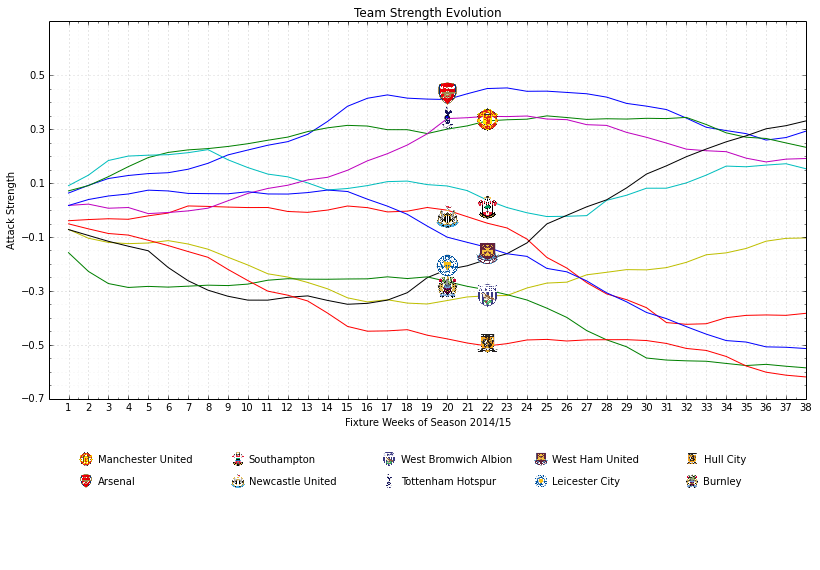

In [317]:
gs = gridspec.GridSpec(2, 1, width_ratios=[1,1], height_ratios=[3.5,1])

fig = plt.figure(figsize=(22, 8))

ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])

ax1.axis([0, 38, -0.7, 0.7])

ax1.set_xticks(np.arange(1, 39, 1))
ax1.set_xticks(np.arange(1, 38, 0.5), minor=True)
ax1.set_yticks(np.arange(-0.7, 0.55, 0.2))
ax1.set_yticks(np.arange(-0.7, 0.5, 0.05), minor=True)                                                     

ax1.yaxis.grid(True, which='major', alpha=0.3)
ax1.yaxis.grid(True, which='minor', alpha=0.1)
ax1.xaxis.grid(True, which='major', alpha=0.3)
ax1.xaxis.grid(True, which='minor', alpha=0.1)

c=0
for i in np.arange(0,20,2):
    ax1.plot(xs, atts[i], marker='None', markersize=10, label="teams['team'][i]")
#     lowerbound, upperbound = 1, 2

#     lb = mcis[i][lowerbound]
#     ub = mcis[i][upperbound]
    
#     ax1.errorbar(xs, atts[i], yerr=[lb, ub], fmt='o')

    if (c % 2 == 0):
        x = 20
        y = atts[i][20]
    else:
        x = 22
        y = atts[i][22]
        
    team = teams['team'][i]
    team_path = team.lower().replace(" ", "_")
    
    ax1.scatter(x,y)
    
    file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team_path +  "_1.png", asfileobj=False)
    icon = read_png(file)
    imagebox = OffsetImage(icon, zoom=0.09)

    ab = AnnotationBbox(imagebox, (x,y), frameon=False)
    ax1.add_artist(ab)
    
    c += 1
    
ax2.axis('off')
ax2.axis([0, 1, 0.5, 1])

c = 0
for i in np.arange(0,20,2):
    if (c < 2):
        x = 0
        y = 0.1*c
    elif (c < 4):
        x = 0.2
        y = 0.1*(c-2)
    elif (c < 6):
        x = 0.4
        y = 0.1*(c-4)
    elif (c < 8):
        x = 0.6
        y = 0.1*(c-6)
    elif (c < 10):
        x = 0.8
        y = 0.1*(c-8)
    
    team = teams['team'][i]
    team_path = team.lower().replace(" ", "_")
    
    file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team_path +  "_1.png", asfileobj=False)
    icon = read_png(file)
    imagebox = OffsetImage(icon, zoom=0.055)

    crest = AnnotationBbox(imagebox, (x+0.05,y+0.015+0.8), frameon=False)
    ax2.add_artist(crest)
    ax2.annotate(team, xy=(x+0.015+0.05,y+0.8))
    
    c += 1


ax1.set_ylabel('Attack Strength')
ax1.set_xlabel('Fixture Weeks of Season 2014/15')
ax1.set_title("Team Strength Evolution")
    
fig.tight_layout()
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/evolution-parameters.pdf",bbox_inches='tight')
plt.show()

## Plot evolution of parameter estimates, when modelled explicitely

In [403]:
# Load summary statistics from pickle (Remote)
t1 = pickle.load(open("t1.p","rb" ))
t38 = pickle.load(open("t38.p","rb" ))

In [404]:
tr_atts38 = t38[0]
tr_defs38 = t38[1]
tr_global38 = t38[2]

tr_atts1 = t1[0]
tr_defs1 = t1[1]
tr_global1 = t1[2]

xs = range(0,10000)

## Uncertainty Plots with increasing observations

In [338]:
# Calculate 95% CI
def mci(samples):
    lb = np.percentile(samples, 2.5, axis=1)
    mn = np.mean(samples, axis=1)
    md = np.percentile(samples, 50, axis=1)
    ub = np.percentile(samples, 97.5, axis=1)
    return md, mn, lb, ub

In [86]:
import pickle

att_mcis = pickle.load(open("att_mcis.p","rb" ))
att_mcis.shape

def_mcis = pickle.load(open("def_mcis.p","rb"))
def_mcis.shape

xs = range(1,38+1)

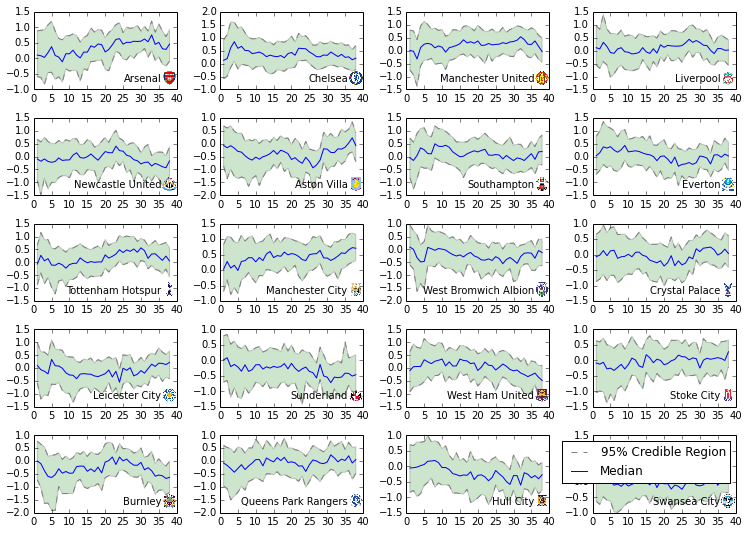

In [381]:
fig, ax = plt.subplots(5,4,figsize=(10.5,7.5))
c = 0
for i in range(0,5):
    for j in range(0,4):
        md = att_mcis[c][0]
        mn = att_mcis[c][1]
        lb = att_mcis[c][2]
        ub = att_mcis[c][3]

        ax[i][j].plot(xs, lb, '--', color='0.5', label='95% Credible Region')
        ax[i][j].plot(xs, md, marker=None, markersize=10, label='Median')
#         ax[i][j].plot(xs, mn, marker=None, markersize=10, label='Mean')
        ax[i][j].plot(xs, ub, '--', color='0.5')
        ax[i][j].fill_between(xs, lb, ub, facecolor='green', alpha=0.2)
        
        team = teams['team'][c].lower().replace(" ", "_")
        team_name = teams['team'][c]

        file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
        icon = read_png(file)
        imagebox = OffsetImage(icon, zoom=0.055)

        crest = AnnotationBbox(imagebox, xycoords='axes fraction', xy=(1-0.05,0.15), frameon=False)
        ax[i][j].add_artist(crest)
        ax[i][j].annotate(teams["team"][c], xycoords='axes fraction', xy=(1-0.110,0.075),
                         horizontalalignment='right', verticalalignment='bottom')
        
        c += 1
#     ax[i].set_ylabel('Attack Strength')
#     ax[i].set_xlabel('Fixture Weeks of Season 2014/15')
#     ax[i].set_title("Team Strength Evolution")

fig.tight_layout()
plt.legend()
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/evolution-uncertainty-dynamic-atts.pdf",bbox_inches='tight')
plt.show()

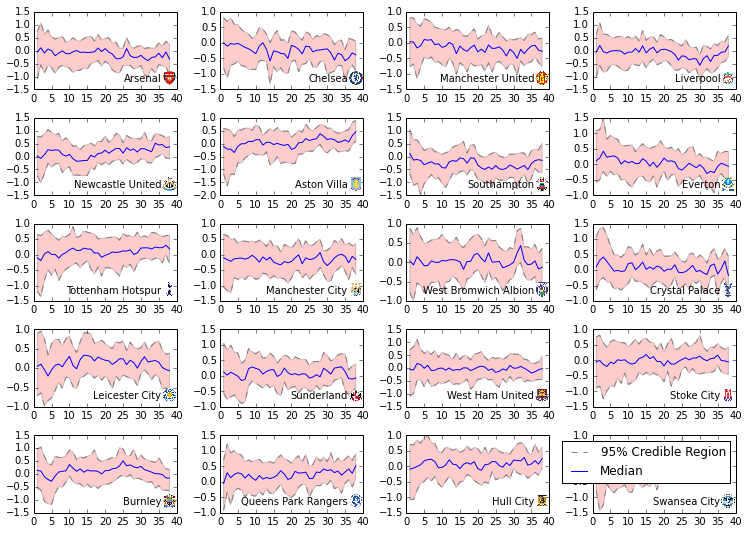

In [377]:
fig, ax = plt.subplots(5,4,figsize=(10.5,7.5))
c = 0
for i in range(0,5):
    for j in range(0,4):
        md = def_mcis[c][0]
        mn = def_mcis[c][1]
        lb = def_mcis[c][2]
        ub = def_mcis[c][3]

        ax[i][j].plot(xs, lb, '--', color='0.5', label='95% Credible Region')
        ax[i][j].plot(xs, md, marker=None, markersize=10, label='Median')
#         ax[i][j].plot(xs, mn, marker=None, markersize=10, label='Mean')
        ax[i][j].plot(xs, ub, '--', color='0.5')
        ax[i][j].fill_between(xs, lb, ub, facecolor='red', alpha=0.2)
        
        team = teams['team'][c].lower().replace(" ", "_")
        team_name = teams['team'][c]

        file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
        icon = read_png(file)
        imagebox = OffsetImage(icon, zoom=0.055)

        crest = AnnotationBbox(imagebox, xycoords='axes fraction', xy=(1-0.05,0.15), frameon=False)
        ax[i][j].add_artist(crest)
        ax[i][j].annotate(teams["team"][c], xycoords='axes fraction', xy=(1-0.110,0.075),
                         horizontalalignment='right', verticalalignment='bottom')
        
        c += 1
#     ax[i].set_ylabel('Attack Strength')
#     ax[i].set_xlabel('Fixture Weeks of Season 2014/15')
#     ax[i].set_title("Team Strength Evolution")

fig.tight_layout()
plt.legend()
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/evolution-uncertainty-dynamic-defs.pdf",bbox_inches='tight')
plt.show()

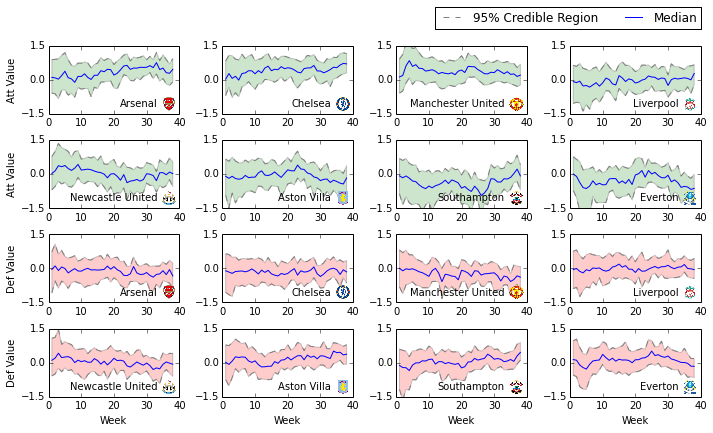

In [92]:
fig, ax = plt.subplots(4,4,figsize=(10,6))
c = 0
team_ix = [0,9,1,15,7,4,5,16]

for i in range(0,4):
    for j in range(0,4):
        cc = team_ix[c]
        
        att_md = att_mcis[cc][0]
        att_mn = att_mcis[cc][1]
        att_lb = att_mcis[cc][2]
        att_ub = att_mcis[cc][3]

        def_md = def_mcis[cc][0]
        def_mn = def_mcis[cc][1]
        def_lb = def_mcis[cc][2]
        def_ub = def_mcis[cc][3]
        
        if (i < 2):
            if (j == 0): ax[i][j].set_ylabel('Att Value')
            ax[i][j].axis([0, 40, -1.5, 1.5])
            ax[i][j].set_xticks(np.arange(0, 41, 10))
            ax[i][j].set_yticks(np.arange(-1.5, 1.51, 1.5))
            
            ax[i][j].plot(xs, att_lb, '--', color='0.5', label='95% Credible Region')
            ax[i][j].plot(xs, att_md, marker=None, markersize=10, label='Median')
            ax[i][j].plot(xs, att_ub, '--', color='0.5')
            ax[i][j].fill_between(xs, att_lb, att_ub, facecolor='green', alpha=0.2)
        else:
            if (j == 0): ax[i][j].set_ylabel('Def Value')
            if (i == 3): ax[i][j].set_xlabel('Week')
            ax[i][j].axis([0, 40, -1.5, 1.5])
            ax[i][j].set_xticks(np.arange(0, 41, 10))
            ax[i][j].set_yticks(np.arange(-1.5, 1.51, 1.5))
                                          
            ax[i][j].plot(xs, def_lb, '--', color='0.5', label='95% Credible Region')
            ax[i][j].plot(xs, def_md, marker=None, markersize=10, label='Median')
            ax[i][j].plot(xs, def_ub, '--', color='0.5')
            ax[i][j].fill_between(xs, def_lb, def_ub, facecolor='red', alpha=0.2)
        
        team = teams['team'][c].lower().replace(" ", "_")
        team_name = teams['team'][c]

        file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
        icon = read_png(file)
        imagebox = OffsetImage(icon, zoom=0.055)

        crest = AnnotationBbox(imagebox, xycoords='axes fraction', xy=(1-0.08,0.15), frameon=False)
        ax[i][j].add_artist(crest)
        ax[i][j].annotate(teams["team"][c], xycoords='axes fraction', xy=(1-0.175,0.075),
                         horizontalalignment='right', verticalalignment='bottom')
        
        if (c == 7): c = 0
        else: c += 1

fig.tight_layout()
ax[0][3].legend(loc='upper right', bbox_to_anchor=(1.05, 1.66), ncol=2)
plt.subplots_adjust(top=0.9)
# plt.suptitle('Median Out-of-Sample predicted Parameter Estimates')
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/evolution-uncertainty-dynamic-atts-8.pdf",bbox_inches='tight')
plt.show()

## Correlation btw. latent parameters